<a href="https://colab.research.google.com/github/AlexandreAdam/torch_score_models/blob/master/score_based_modeling_overview_interactive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Utility functions
!pip install torchquad --quiet

%matplotlib inline

import torch
import numpy
import matplotlib.pyplot as plt
import torch.distributions as tfd
import numpy as np
from tqdm import tqdm
from scipy.interpolate import interpn
from matplotlib.colors import Normalize
import matplotlib.pylab as pylab
import matplotlib.cm as cm
plt.style.use("dark_background")
params = {
    'legend.fontsize': 20,
    'figure.figsize': (5, 5),
    'axes.labelsize': 20,
    'axes.titlesize': 25,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'figure.titlesize': 25,
    'xtick.major.size': 8,
    'xtick.minor.size': 4,
    'xtick.major.width': 1,
    'xtick.minor.width': 1,
    'ytick.major.size': 8,
    'ytick.minor.size': 4,
    'ytick.major.width': 1,
    'ytick.minor.width': 1,
    'font.size': 20 # for annotate
}
pylab.rcParams.update(params)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 788.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.0 MB/s eta 0:00:00


In [2]:
!pip install score_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 791.6 kB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [3]:
#@title Additional imports
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from score_models import ScoreModel, NCSNpp
from torch.utils.data import Dataset

In [4]:
#@title Download the MNIST dataset

# a wrapper class to handle sending MNIST data to device
class MNISTDataset(Dataset):
    def __init__(self, root, train=True, transform=None, download=True):
        self.mnist = MNIST(root, train=train, download=download)
        self.transform = transform

    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, index):
        img, target = self.mnist[index]

        if self.transform:
            img = self.transform(img)

        return img.to(DEVICE), target

dataset = MNISTDataset('.', train=True, transform=transforms.ToTensor())
dimensions = dataset.mnist.data.shape[1:]

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17615162.31it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 493420.40it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4503597.79it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9352247.80it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



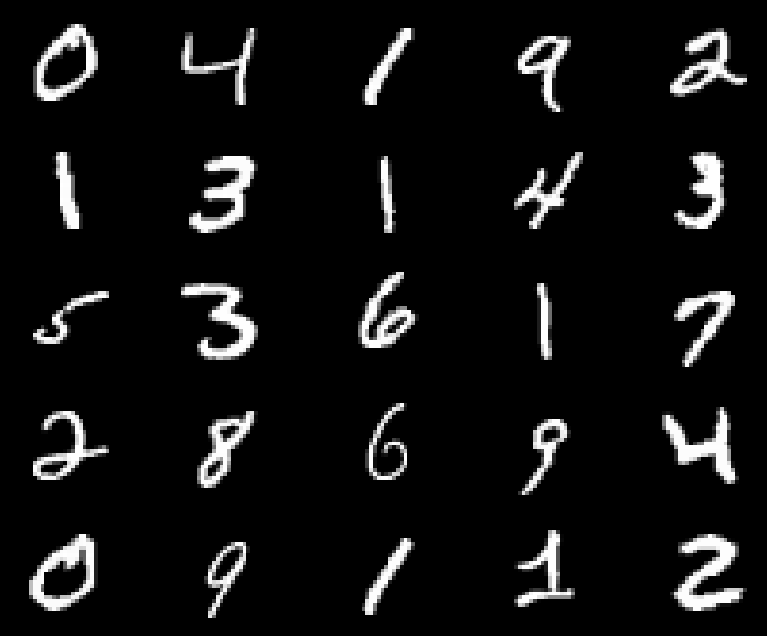

In [5]:
#Look at the first few elements of the training set
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    img, label = dataset[i]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze().cpu(), cmap="gray")
plt.show()

In [6]:
C = 1 # one channel for grayscale images [0, 255]
B = 128 # batch size
checkpoints_directory = "checkpoints"
net = NCSNpp(channels=C, dimensions=len(dimensions), nf=64, ch_mult=[2, 2, 2])
model = ScoreModel(model=net, sigma_min=1e-2, sigma_max=50, device=DEVICE)

Using the Variance Exploding SDE


In [7]:
#For me, training takes about 45 minutes for 10 epochs B=128 using the colab T4 GPU
losses = model.fit(dataset, epochs=10, batch_size=B, learning_rate=1e-4, checkpoints_directory=checkpoints_directory)

Epoch 10 | Cost: 3.6e+01 |: 100%|██████████| 10/10 [34:50<00:00, 209.04s/it]

Finished training after 0.581 hours.


In [8]:
#Takes about 3 minutes to sample using 1000 steps
samples = model.sample(shape=[B, C, *dimensions], steps=1000)

Sampling from the prior | t = 0.0 | sigma = 1.0e-02| scale ~ 3.2e-01: 100%|██████████| 1000/1000 [02:39<00:00,  6.28it/s]


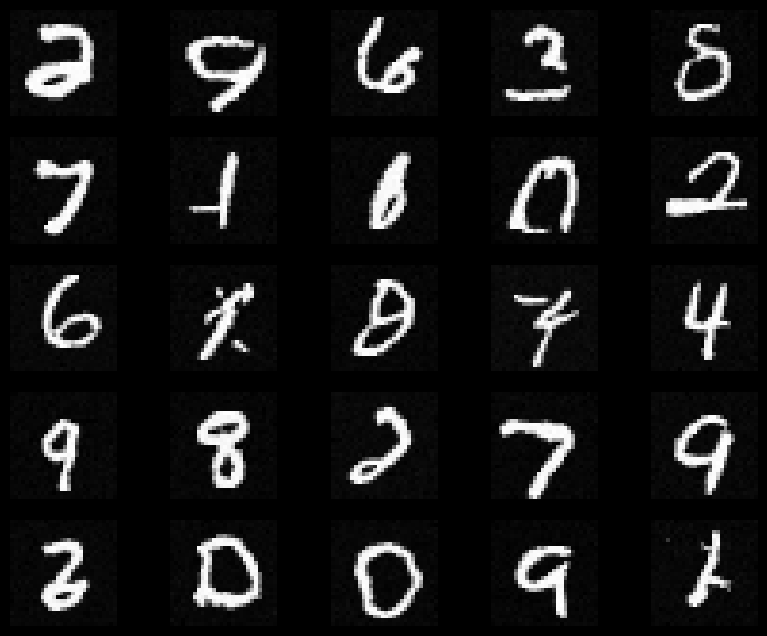

In [11]:
#@title Plot the generated samples
# Not a bad starting point, but can definitely be improved!

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
idxs = np.random.choice(B, cols*rows, replace=False)

for i in range(1, cols * rows + 1):
    img = samples[idxs[i-1]]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze().cpu(), cmap="gray")
plt.show()